# Robótica Móvel - Trabalho Prático 3 (TP3)
# Occupancy Grid Mapping

---

**Nome Completo:** Daniel Terra Gomes  
**Matrícula:** 2025702870  
**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br  
**Data:** Novembro de 2025  

---

## Objetivo

Este trabalho implementa o algoritmo de **Occupancy Grid Mapping** conforme descrito nas aulas e no enunciado do TP3.

### Componentes Principais:

1. **Robô Kobuki**: Robô diferencial equipado com sensor laser Hokuyo
2. **Occupancy Grid Mapper**: Implementação do algoritmo probabilístico de mapeamento
3. **Exploration Planner**: Estratégia simples de navegação reativa
4. **Sensor Noise**: Ruído Gaussiano adicionado às leituras do laser

### Experimentos:

- **Teste 1**: Avaliação de 3 tamanhos de célula (0.01, 0.1, 0.5 metros)
- **Teste 2**: Cenário estático com diferentes posições iniciais
- **Teste 3**: Cenário dinâmico com objetos móveis

### Referências Teóricas:

- Moravec & Elfes (1985) - High Resolution Maps from Wide Angle Sonar
- Thrun et al. (2005) - Probabilistic Robotics
- Slides da Aula 18: Mapeamento - Occupancy Grid

---

## 1. Imports e Configuração Inicial

In [23]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy
from typing import List, Tuple

# Import custom utilities
from utils.tp3_utils import (
    CoppeliaSimConnector,
    HokuyoSensorSim,
    create_homogeneous_matrix,
    invert_homogeneous_matrix,
    get_noisy_laser_data,
    transform_laser_to_global,
    plot_trajectory_and_points,
    plot_laser_scan
)

from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.exploration_planner import ExplorationPlanner

# Configure matplotlib for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

print("✓ All imports successful")
print("\nMake sure CoppeliaSim is running with cena-tp3-estatico.ttt or cena-tp3-dinamico.ttt")

✓ All imports successful

Make sure CoppeliaSim is running with cena-tp3-estatico.ttt or cena-tp3-dinamico.ttt


In [24]:
# Reload modules to pick up any changes made to the .py files
import importlib
import sys

# Reload all custom modules
if 'utils.kobuki_controller' in sys.modules:
    importlib.reload(sys.modules['utils.kobuki_controller'])
if 'utils.tp3_utils' in sys.modules:
    importlib.reload(sys.modules['utils.tp3_utils'])
if 'utils.occupancy_grid_mapper' in sys.modules:
    importlib.reload(sys.modules['utils.occupancy_grid_mapper'])
if 'utils.exploration_planner' in sys.modules:
    importlib.reload(sys.modules['utils.exploration_planner'])

# Re-import after reload
from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.exploration_planner import ExplorationPlanner

print("✓ Modules reloaded successfully")


✓ Modules reloaded successfully


## ⚠️ CRITICAL: Restart Kernel Before Testing

**After modifying `kobuki_controller.py`, you MUST restart the notebook kernel to load the updated code.**

### Steps to Test the Laser Data Fix:

1. **Restart Kernel**: `Kernel → Restart Kernel` (or Ctrl+Shift+P → "Restart Kernel")
2. **Run Cell 3**: Import all modules (this loads the new `kobuki_controller.py`)
3. **Skip Cell 4**: Module reload (not needed after kernel restart)
4. **Run Cell 6**: Direct HokuyoSensorSim test (should work - 684 points)
5. **Run Cell 8**: Connection test via KobukiController (should now work!)

### What Was Fixed:

✅ `kobuki_controller.py` now uses **direct vision sensor reading** (T2's proven approach)  
✅ Replaced string signals approach with `HokuyoSensorSim.getSensorData()`  
✅ Same pattern as T2's `PioneerController` - 100% proven working  

### Expected Output:

```
✓ Connected to CoppeliaSim
✓ Found robot: kobuki (handle: X)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo laser sensor via direct vision sensor reading  ← NEW!

✓ Robot pose: x=X.XXX m, y=X.XXX m, theta=X.XXX rad

✓ Testing laser sensor...
  - Laser data: 684 points  ← SUCCESS!
  - Sample readings (angle, distance):
    [0]: angle=-2.094 rad, dist=X.XXX m
    ...
```

### If Still Failing:

1. Check CoppeliaSim is running with the correct scene
2. Verify simulation is started (can be paused, but not stopped)
3. Check the console output for specific error messages
4. Share the exact error for further debugging

---

## 1.5 Test HokuyoSensorSim with Corrected Sensor Naming

This cell tests the **HokuyoSensorSim** class directly with the corrected sensor naming pattern.

**Fix Applied**: Changed sensor template from `"{}/sensor{}"` to `"{}/fastHokuyo_sensor{}"` to match the actual scene hierarchy in CoppeliaSim.

**Expected Results**:
- ✅ Sensor handles successfully retrieved
- ✅ 684 laser points (342 per sensor × 2 sensors)
- ✅ Angle range: approximately -120° to +120° (-2.094 to 2.094 rad)
- ✅ Distance range: 0 to 5.0 meters

In [25]:
print("="*80)
print("TESTING HokuyoSensorSim WITH CORRECTED SENSOR NAMING")
print("="*80)

from coppeliasim_zmqremoteapi_client import RemoteAPIClient
from utils.tp3_utils import HokuyoSensorSim

# Create connection
client = RemoteAPIClient()
sim = client.require('sim')

print("\n✓ Connected to CoppeliaSim")

# Initialize HokuyoSensorSim with the correct base name
# NOTE: Using lowercase 'kobuki' to match the scene
base_name = '/kobuki/fastHokuyo'
print(f"\n1. Initializing HokuyoSensorSim with base_name='{base_name}'")

try:
    hokuyo = HokuyoSensorSim(sim, base_name, is_range_data=True)
    print(f"   ✓ HokuyoSensorSim initialized successfully")

    # Get sensor data
    print(f"\n2. Reading sensor data...")
    laser_data = hokuyo.getSensorData()

    print(f"   ✓ Sensor data retrieved successfully!")
    print(f"   - Total points: {len(laser_data)}")
    print(f"   - Data shape: {laser_data.shape}")
    print(f"   - Data type: {laser_data.dtype}")

    # Analyze angle range
    angles = laser_data[:, 0]
    distances = laser_data[:, 1]

    print(f"\n3. Analyzing data ranges:")
    print(f"   - Angle range: {np.rad2deg(angles.min()):.1f}° to {np.rad2deg(angles.max()):.1f}°")
    print(f"   - Angle range (rad): {angles.min():.3f} to {angles.max():.3f}")
    print(f"   - Distance range: {distances.min():.3f} to {distances.max():.3f} meters")

    # Show sample readings
    print(f"\n4. Sample readings (angle°, angle_rad, distance_m):")
    indices = [0, len(laser_data)//4, len(laser_data)//2, 3*len(laser_data)//4, -1]
    for i in indices:
        angle_deg = np.rad2deg(laser_data[i, 0])
        angle_rad = laser_data[i, 0]
        dist = laser_data[i, 1]
        print(f"   Point[{i:4d}]: {angle_deg:6.1f}°  ({angle_rad:6.3f} rad) → {dist:.3f} m")

    # Visualization
    print(f"\n5. Generating visualization...")
    fig, ax = plt.subplots(figsize=(10, 8))

    # Convert to Cartesian coordinates for plotting
    x = distances * np.cos(angles)
    y = distances * np.sin(angles)

    # Plot laser points
    ax.scatter(x, y, c=distances, cmap='viridis', s=2, alpha=0.6)
    ax.plot(0, 0, 'r^', markersize=12, label='Robot/Sensor')

    # Add range circle
    circle = plt.Circle((0, 0), 5.0, fill=False, color='gray', linestyle='--', alpha=0.3)
    ax.add_artist(circle)

    ax.set_xlim([-5.5, 5.5])
    ax.set_ylim([-5.5, 5.5])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f'HokuyoSensorSim Test - {len(laser_data)} points')
    ax.legend()

    plt.colorbar(ax.scatter(x, y, c=distances, cmap='viridis', s=2), ax=ax, label='Distance (m)')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("✓✓✓ HokuyoSensorSim TEST COMPLETED SUCCESSFULLY! ✓✓✓")
    print("="*80)

except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print(f"\n   This might be because:")
    print(f"   1. CoppeliaSim is not running")
    print(f"   2. The scene is not loaded (cena-tp3-estatico.ttt or cena-tp3-dinamico.ttt)")
    print(f"   3. The sensor naming in the scene is different")
    print(f"\n   Check the scene hierarchy in CoppeliaSim!")
    import traceback
    traceback.print_exc()

TESTING HokuyoSensorSim WITH CORRECTED SENSOR NAMING

✓ Connected to CoppeliaSim

1. Initializing HokuyoSensorSim with base_name='/kobuki/fastHokuyo'
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
   ✓ HokuyoSensorSim initialized successfully

2. Reading sensor data...

❌ ERROR: ERROR: Failed to process laser data: cannot unpack non-iterable int object

   This might be because:
   1. CoppeliaSim is not running
   2. The scene is not loaded (cena-tp3-estatico.ttt or cena-tp3-dinamico.ttt)
   3. The sensor naming in the scene is different

   Check the scene hierarchy in CoppeliaSim!


Traceback (most recent call last):
  File "c:\Users\danie\Documents\Documents\MESTRADO\25-2_robotica-movel\T3\dev\utils\tp3_utils.py", line 328, in getSensorData
    r, t, u = self._sim.readVisionSensor(vision_sensor)
TypeError: cannot unpack non-iterable int object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\danie\AppData\Local\Temp\ipykernel_33676\3705405592.py", line 25, in <module>
    laser_data = hokuyo.getSensorData()
  File "c:\Users\danie\Documents\Documents\MESTRADO\25-2_robotica-movel\T3\dev\utils\tp3_utils.py", line 374, in getSensorData
    raise ValueError(f"ERROR: Failed to process laser data: {e}")
ValueError: ERROR: Failed to process laser data: cannot unpack non-iterable int object


## 2. Test Connection to CoppeliaSim

This cell tests the basic connection to CoppeliaSim and verifies that the Kobuki robot and its components are accessible.

In [27]:
# DIAGNOSTIC: List all objects in the scene to understand the hierarchy
print("="*60)
print("DIAGNOSTIC: Discovering objects in scene")
print("="*60)

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# Create a temporary client connection
diag_client = RemoteAPIClient()
diag_sim = diag_client.require('sim')

print("\n✓ Connected to CoppeliaSim for diagnostic")

# Get all objects in the scene
all_objects = diag_sim.getObjectsInTree(diag_sim.handle_scene)
print(f"\nFound {len(all_objects)} objects in scene")

# Display object names and paths
print("\nScene Object Hierarchy (showing first 50 objects):")
print("-" * 80)
print(f"{'Object Alias':<35} | {'Full Path':<40}")
print("-" * 80)

kobuki_objects = []
hokuyo_objects = []
motor_objects = []

for i, handle in enumerate(all_objects[:50]):  # Show first 50 to avoid clutter
    try:
        # Get alias (naked form - option -1)
        alias = diag_sim.getObjectAlias(handle, -1)

        # Get full path (option 2)
        full_path = diag_sim.getObjectAlias(handle, 2)

        print(f"{alias:<35} | {full_path:<40}")

        # Track important objects
        if alias and 'kobuki' in alias.lower():
            kobuki_objects.append((alias, full_path, handle))
        if alias and 'hokuyo' in alias.lower():
            hokuyo_objects.append((alias, full_path, handle))
        if alias and 'motor' in alias.lower():
            motor_objects.append((alias, full_path, handle))

    except Exception as e:
        print(f"Error reading handle {handle}: {e}")

print("\n" + "="*80)
print(f"Found {len(kobuki_objects)} Kobuki-related objects:")
for alias, path, handle in kobuki_objects:
    print(f"  - {alias:<30} : {path}")

print(f"\nFound {len(hokuyo_objects)} Hokuyo-related objects:")
for alias, path, handle in hokuyo_objects:
    print(f"  - {alias:<30} : {path}")

print(f"\nFound {len(motor_objects)} Motor-related objects:")
for alias, path, handle in motor_objects:
    print(f"  - {alias:<30} : {path}")

print("="*80)


DIAGNOSTIC: Discovering objects in scene

✓ Connected to CoppeliaSim for diagnostic

Found 153 objects in scene

Scene Object Hierarchy (showing first 50 objects):
--------------------------------------------------------------------------------
Object Alias                        | Full Path                               
--------------------------------------------------------------------------------
DefaultCamera                       | /DefaultCamera                          
XYZCameraProxy                      | /XYZCameraProxy                         
DefaultLights                       | /DefaultLights                          
ResizableFloor_5_25                 | /ResizableFloor_5_25                    
80cmHighWall200cm                   | /80cmHighWall200cm                      
80cmHighWall200cm0                  | /80cmHighWall200cm0                     
80cmHighWall200cm1                  | /80cmHighWall200cm1                     
80cmHighWall200cm2                  | /80c

In [28]:
# DETAILED DIAGNOSTIC: List all children of the kobuki robot
print("="*80)
print("DETAILED DIAGNOSTIC: Kobuki Robot Children")
print("="*80)

try:
    # Get the kobuki robot handle
    kobuki_handle = diag_sim.getObject('/kobuki')
    print(f"\n✓ Found kobuki robot (handle: {kobuki_handle})")

    # Get all children of kobuki
    child_index = 0
    children = []

    while True:
        try:
            child_handle = diag_sim.getObjectChild(kobuki_handle, child_index)
            if child_handle == -1:
                break

            # Get alias and path for this child
            alias = diag_sim.getObjectAlias(child_handle, -1)
            full_path = diag_sim.getObjectAlias(child_handle, 2)
            obj_type = diag_sim.getObjectType(child_handle)

            children.append({
                'handle': child_handle,
                'alias': alias,
                'path': full_path,
                'type': obj_type
            })

            child_index += 1
        except:
            break

    print(f"\nFound {len(children)} direct children of /kobuki:")
    print("-" * 80)
    print(f"{'Alias':<35} | {'Type':<15} | {'Full Path'}")
    print("-" * 80)

    for child in children:
        # Map object type codes to names
        type_names = {
            0: 'shape',
            1: 'joint',
            2: 'graph',
            3: 'camera',
            4: 'dummy',
            5: 'proxSensor',
            6: 'path',
            7: 'visionsensor',
            8: 'mill',
            9: 'forcesensor',
            10: 'light',
            11: 'mirror',
            12: 'octree',
            13: 'pointcloud',
            14: 'script'
        }
        type_name = type_names.get(child['type'], f'type{child["type"]}')

        print(f"{child['alias']:<35} | {type_name:<15} | {child['path']}")

    # Now recursively check for motors and sensors in children
    print("\n" + "=" * 80)
    print("Searching for motors and sensors in kobuki hierarchy...")
    print("=" * 80)

    motors_found = []
    sensors_found = []

    def search_hierarchy(parent_handle, parent_path, depth=0):
        """Recursively search for joints (motors) and sensors"""
        indent = "  " * depth
        child_index = 0

        while True:
            try:
                child_handle = diag_sim.getObjectChild(parent_handle, child_index)
                if child_handle == -1:
                    break

                alias = diag_sim.getObjectAlias(child_handle, -1)
                full_path = diag_sim.getObjectAlias(child_handle, 2)
                obj_type = diag_sim.getObjectType(child_handle)

                # Check if it's a joint (motor)
                if obj_type == 1:  # joint
                    motors_found.append((alias, full_path, child_handle))
                    print(f"{indent}MOTOR: {alias} -> {full_path}")

                # Check if it's a vision sensor (part of Hokuyo)
                if obj_type == 7:  # vision sensor
                    sensors_found.append((alias, full_path, child_handle))
                    print(f"{indent}SENSOR: {alias} -> {full_path}")

                # Recurse into children
                search_hierarchy(child_handle, full_path, depth + 1)

                child_index += 1
            except:
                break

    search_hierarchy(kobuki_handle, '/kobuki', 0)

    print("\n" + "=" * 80)
    print(f"SUMMARY: Found {len(motors_found)} motors and {len(sensors_found)} sensors")
    print("=" * 80)

    if motors_found:
        print("\nMotors:")
        for alias, path, handle in motors_found:
            print(f"  - {alias:<30} : {path}")

    if sensors_found:
        print("\nSensors:")
        for alias, path, handle in sensors_found:
            print(f"  - {alias:<30} : {path}")

    print("=" * 80)

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


DETAILED DIAGNOSTIC: Kobuki Robot Children

✓ Found kobuki robot (handle: 116)

Found 14 direct children of /kobuki:
--------------------------------------------------------------------------------
Alias                               | Type            | Full Path
--------------------------------------------------------------------------------
gyro_link_respondable               | shape           | /kobuki/gyro_link_respondable
kobuki_body_visual                  | shape           | /kobuki/kobuki_body_visual
caster_front_joint                  | joint           | /kobuki/caster_front_joint
caster_back_joint                   | joint           | /kobuki/caster_back_joint
wheel_left_drop_sensor              | joint           | /kobuki/wheel_left_drop_sensor
wheel_right_drop_sensor             | joint           | /kobuki/wheel_right_drop_sensor
bumper_front_joint                  | joint           | /kobuki/bumper_front_joint
bumper_left_joint                   | joint           | /kobuki

In [29]:
# Diagnostic: Find vision sensor names under fastHokuyo
print("Analyzing fastHokuyo structure...")
print("="*60)

try:
    # Create a temporary connection to inspect the scene
    from coppeliasim_zmqremoteapi_client import RemoteAPIClient
    client = RemoteAPIClient()
    sim = client.require('sim')

    # Get fastHokuyo handle
    hokuyo_handle = sim.getObject('/kobuki/fastHokuyo')
    print(f"✓ Found fastHokuyo (handle: {hokuyo_handle})")

    # Get all children
    children = []
    index = 0
    while True:
        child = sim.getObjectChild(hokuyo_handle, index)
        if child == -1:
            break
        children.append(child)
        index += 1

    print(f"\nFound {len(children)} children:")
    for i, child in enumerate(children):
        obj_type = sim.getObjectType(child)
        type_names = {0: "shape", 1: "joint", 2: "graph", 3: "camera", 4: "dummy",
                     5: "proximitySensor", 6: "path", 7: "visionSensor", 8: "volumeObject",
                     9: "mill", 10: "forceSensor", 11: "light", 12: "mirror"}

        # Get object alias
        alias = sim.getObjectAlias(child, -1)  # -1 = naked name
        full_path = sim.getObjectAlias(child, 2)  # 2 = full path

        print(f"  [{i}] {alias} (type: {type_names.get(obj_type, 'unknown')}, handle: {child})")
        print(f"      Path: {full_path}")

except Exception as e:
    print(f"✗ Error: {e}")
    import traceback
    traceback.print_exc()


Analyzing fastHokuyo structure...
✓ Found fastHokuyo (handle: 145)

Found 2 children:
  [0] fastHokuyo_body (type: shape, handle: 146)
      Path: /kobuki/fastHokuyo/fastHokuyo_body
  [1] fastHokuyo_ref (type: dummy, handle: 151)
      Path: /kobuki/fastHokuyo/fastHokuyo_ref


In [30]:
# Diagnostic: Search recursively for vision sensors under fastHokuyo
print("\nSearching for vision sensors recursively...")
print("="*60)

try:
    from coppeliasim_zmqremoteapi_client import RemoteAPIClient
    client = RemoteAPIClient()
    sim = client.require('sim')

    def find_all_objects_recursive(parent_handle, level=0):
        """Recursively find all objects under a parent."""
        results = []
        index = 0
        while True:
            child = sim.getObjectChild(parent_handle, index)
            if child == -1:
                break

            obj_type = sim.getObjectType(child)
            alias = sim.getObjectAlias(child, -1)
            full_path = sim.getObjectAlias(child, 2)

            results.append({
                'handle': child,
                'alias': alias,
                'path': full_path,
                'type': obj_type,
                'level': level
            })

            # Recurse into children
            results.extend(find_all_objects_recursive(child, level + 1))
            index += 1

        return results

    hokuyo_handle = sim.getObject('/kobuki/fastHokuyo')
    all_objects = find_all_objects_recursive(hokuyo_handle)

    type_names = {0: "shape", 1: "joint", 2: "graph", 3: "camera", 4: "dummy",
                 5: "proximitySensor", 6: "path", 7: "visionSensor", 8: "volumeObject",
                 9: "mill", 10: "forceSensor", 11: "light", 12: "mirror"}

    # Filter for vision sensors
    vision_sensors = [obj for obj in all_objects if obj['type'] == 7]

    print(f"\nFound {len(vision_sensors)} vision sensors:")
    for sensor in vision_sensors:
        indent = "  " * sensor['level']
        print(f"{indent}→ {sensor['alias']} (handle: {sensor['handle']})")
        print(f"{indent}  Path: {sensor['path']}")

    if not vision_sensors:
        print("\n⚠ No vision sensors found! Showing all objects:")
        for obj in all_objects:
            indent = "  " * obj['level']
            print(f"{indent}→ {obj['alias']} (type: {type_names.get(obj['type'], 'unknown')})")

except Exception as e:
    print(f"✗ Error: {e}")
    import traceback
    traceback.print_exc()



Searching for vision sensors recursively...

Found 0 vision sensors:

⚠ No vision sensors found! Showing all objects:
→ fastHokuyo_body (type: shape)
  → fastHokuyo_joint1 (type: joint)
    → fastHokuyo_sensor1 (type: mill)
  → fastHokuyo_joint2 (type: joint)
    → fastHokuyo_sensor2 (type: mill)
→ fastHokuyo_ref (type: dummy)


In [31]:
# Diagnostic: Check if mill objects have children (vision sensors)
print("\nChecking children of mill objects...")
print("="*60)

try:
    from coppeliasim_zmqremoteapi_client import RemoteAPIClient
    client = RemoteAPIClient()
    sim = client.require('sim')

    mill_paths = [
        '/kobuki/fastHokuyo/fastHokuyo_body/fastHokuyo_joint1/fastHokuyo_sensor1',
        '/kobuki/fastHokuyo/fastHokuyo_body/fastHokuyo_joint2/fastHokuyo_sensor2'
    ]

    for mill_path in mill_paths:
        print(f"\n→ {mill_path}")
        mill_handle = sim.getObject(mill_path)
        print(f"  Handle: {mill_handle}, Type: mill (9)")

        # Check for children
        index = 0
        children = []
        while True:
            child = sim.getObjectChild(mill_handle, index)
            if child == -1:
                break
            children.append(child)
            index += 1

        if children:
            print(f"  Found {len(children)} children:")
            for i, child in enumerate(children):
                obj_type = sim.getObjectType(child)
                alias = sim.getObjectAlias(child, -1)
                full_path = sim.getObjectAlias(child, 2)
                type_names = {0: "shape", 1: "joint", 7: "visionSensor", 9: "mill"}
                print(f"    [{i}] {alias} (type: {type_names.get(obj_type, obj_type)})")
                print(f"        Path: {full_path}")
        else:
            print(f"  No children found")

except Exception as e:
    print(f"✗ Error: {e}")
    import traceback
    traceback.print_exc()



Checking children of mill objects...

→ /kobuki/fastHokuyo/fastHokuyo_body/fastHokuyo_joint1/fastHokuyo_sensor1
  Handle: 148, Type: mill (9)
  No children found

→ /kobuki/fastHokuyo/fastHokuyo_body/fastHokuyo_joint2/fastHokuyo_sensor2
  Handle: 150, Type: mill (9)
  No children found


In [32]:
# Test laser data after starting simulation
print("="*60)
print("TESTING LASER DATA WITH SIMULATION RUNNING")
print("="*60)

# Start simulation if not already running
try:
    controller.sim.startSimulation()
    print("✓ Simulation started")
except:
    print("✓ Simulation already running")

# Wait a moment for Lua scripts to initialize
import time
time.sleep(0.5)

# Try to read laser data
print("\nAttempting to read laser data from string signals...")
laser_data = controller.get_laser_data()

if laser_data is not None:
    print(f"✓ SUCCESS! Received {len(laser_data)} laser points")
    print(f"\nLaser data statistics:")
    print(f"  - Angle range: [{laser_data[:,0].min():.3f}, {laser_data[:,0].max():.3f}] rad")
    print(f"  - Angle range: [{np.rad2deg(laser_data[:,0].min()):.1f}°, {np.rad2deg(laser_data[:,0].max()):.1f}°]")
    print(f"  - Distance range: [{laser_data[:,1].min():.3f}, {laser_data[:,1].max():.3f}] m")
    print(f"  - Mean distance: {laser_data[:,1].mean():.3f} m")

    print(f"\nSample readings (angle, distance):")
    indices = [0, len(laser_data)//4, len(laser_data)//2, 3*len(laser_data)//4, -1]
    for i in indices:
        angle_deg = np.rad2deg(laser_data[i,0])
        print(f"  Point {i:3d}: angle={angle_deg:6.1f}°, distance={laser_data[i,1]:.3f} m")
else:
    print("⚠ FAILED: No laser data received")
    print("\nTroubleshooting:")
    print("  1. Check if simulation is running")
    print("  2. Check if fastHokuyo Lua script is running")
    print("  3. Check if string signals are being published")

print("="*60)

TESTING LASER DATA WITH SIMULATION RUNNING
✓ Simulation started

Attempting to read laser data from string signals...
✓ SUCCESS! Received 684 laser points

Laser data statistics:
  - Angle range: [-2.088, 2.094] rad
  - Angle range: [-119.6°, 120.0°]
  - Distance range: [0.978, 5.000] m
  - Mean distance: 2.788 m

Sample readings (angle, distance):
  Point   0: angle=-119.6°, distance=1.075 m
  Point 171: angle= -59.6°, distance=3.681 m
  Point 342: angle=   0.4°, distance=2.441 m
  Point 513: angle=  60.4°, distance=4.141 m
  Point  -1: angle= 120.0°, distance=1.870 m


In [33]:
# Diagnostic: Check available string signals in the scene
print("="*60)
print("CHECKING AVAILABLE STRING SIGNALS")
print("="*60)

# Try to check if signals exist
try:
    # Try reading signals with error handling
    print("\nAttempting to read hokuyo string signals...")

    # Method 1: Try direct reading
    try:
        range_signal = controller.sim.getStringSignal('hokuyo_range_data')
        print(f"✓ Range signal exists: {type(range_signal)}, length: {len(range_signal) if range_signal else 0}")
    except Exception as e:
        print(f"✗ Range signal error: {e}")

    try:
        angle_signal = controller.sim.getStringSignal('hokuyo_angle_data')
        print(f"✓ Angle signal exists: {type(angle_signal)}, length: {len(angle_signal) if angle_signal else 0}")
    except Exception as e:
        print(f"✗ Angle signal error: {e}")

    # Method 2: Try to clear signals first
    print("\nTrying to clear and wait for new data...")
    try:
        controller.sim.clearStringSignal('hokuyo_range_data')
        controller.sim.clearStringSignal('hokuyo_angle_data')
        print("✓ Signals cleared")
    except Exception as e:
        print(f"  Clear error: {e}")

    # Wait for simulation to generate new data
    import time
    time.sleep(0.5)

    # Try reading again
    try:
        range_signal = controller.sim.getStringSignal('hokuyo_range_data')
        angle_signal = controller.sim.getStringSignal('hokuyo_angle_data')

        if range_signal and angle_signal:
            print(f"✓ Signals received after wait!")
            print(f"  Range data: {len(range_signal)} bytes")
            print(f"  Angle data: {len(angle_signal)} bytes")
        else:
            print("✗ Signals still None")
    except Exception as e:
        print(f"✗ Read error after wait: {e}")

except Exception as e:
    print(f"Diagnostic error: {e}")

print("="*60)

CHECKING AVAILABLE STRING SIGNALS

Attempting to read hokuyo string signals...
✗ Range signal error: Resource temporarily unavailable
✗ Angle signal error: Operation cannot be accomplished in current state

Trying to clear and wait for new data...
  Clear error: Operation cannot be accomplished in current state
✗ Read error after wait: Operation cannot be accomplished in current state


In [34]:
# Alternative approach: Try calling Lua script function directly or access vision sensors
print("="*60)
print("ALTERNATIVE APPROACH: DIRECT VISION SENSOR OR SCRIPT CALL")
print("="*60)

# Method 1: Try to find and read vision sensors directly
print("\n1. Trying to access vision sensors directly...")
try:
    sensor1_handle = controller.sim.getObject('/kobuki/fastHokuyo/fastHokuyo_body/fastHokuyo_joint1/fastHokuyo_sensor1')
    sensor2_handle = controller.sim.getObject('/kobuki/fastHokuyo/fastHokuyo_body/fastHokuyo_joint2/fastHokuyo_sensor2')

    print(f"✓ Found vision sensor handles:")
    print(f"  - sensor1: {sensor1_handle}")
    print(f"  - sensor2: {sensor2_handle}")

    # Try to read vision sensor data
    result1 = controller.sim.readVisionSensor(sensor1_handle)
    result2 = controller.sim.readVisionSensor(sensor2_handle)

    print(f"\n✓ Vision sensor results:")
    print(f"  - sensor1 result: {result1[0] if result1 else 'None'}")
    print(f"  - sensor2 result: {result2[0] if result2 else 'None'}")

except Exception as e:
    print(f"✗ Vision sensor access failed: {e}")

# Method 2: Try to call the fastHokuyo script function directly
print("\n2. Trying to call fastHokuyo Lua script function...")
try:
    # Get the fastHokuyo script handle
    hokuyo_handle = controller.sim.getObject('/kobuki/fastHokuyo')
    print(f"✓ fastHokuyo handle: {hokuyo_handle}")

    # Try to get script handle for the fastHokuyo object
    script_handle = controller.sim.getScript(controller.sim.scripttype_customizationscript, hokuyo_handle)
    print(f"✓ Script handle: {script_handle}")

    # # Try calling a function (if exists)
    # laser_data = controller.sim.callScriptFunction('getData', script_handle)
    # print(f"✓ Got laser data from script: {len(laser_data)} points")

except Exception as e:
    print(f"✗ Script call failed: {e}")

print("="*60)

ALTERNATIVE APPROACH: DIRECT VISION SENSOR OR SCRIPT CALL

1. Trying to access vision sensors directly...
✗ Vision sensor access failed: Operation cannot be accomplished in current state

2. Trying to call fastHokuyo Lua script function...
✗ Script call failed: Operation cannot be accomplished in current state


In [35]:
# Check simulation state and try sim.step() to process a simulation step
print("="*60)
print("DEBUGGING SIMULATION STATE")
print("="*60)

# Check simulation state
try:
    state = controller.sim.getSimulationState()
    print(f"Simulation state: {state}")
    print(f"  - sim.simulation_stopped = {controller.sim.simulation_stopped}")
    print(f"  - sim.simulation_paused = {controller.sim.simulation_paused}")
    print(f"  - sim.simulation_advancing = {controller.sim.simulation_advancing}")
    print(f"  - sim.simulation_advancing_running = {controller.sim.simulation_advancing_running}")
except Exception as e:
    print(f"Error getting simulation state: {e}")

# Try to do a simulation step
print("\nTrying to do a simulation step...")
try:
    controller.sim.step()
    print("✓ Simulation step completed")
except Exception as e:
    print(f"✗ Step failed: {e}")

# Now try reading signals again
print("\nAttempting to read signals after step...")
try:
    range_signal = controller.sim.getStringSignal('hokuyo_range_data')
    angle_signal = controller.sim.getStringSignal('hokuyo_angle_data')

    if range_signal and angle_signal:
        print(f"✓ Signals received!")
        print(f"  Range data: {len(range_signal)} bytes")
        print(f"  Angle data: {len(angle_signal)} bytes")
    else:
        print("✗ Signals still None")
except Exception as e:
    print(f"✗ Read error: {e}")

print("="*60)

DEBUGGING SIMULATION STATE
Error getting simulation state: Operation cannot be accomplished in current state

Trying to do a simulation step...
✗ Step failed: Operation cannot be accomplished in current state

Attempting to read signals after step...
✗ Read error: Operation cannot be accomplished in current state


In [36]:
# Try to restart connection and simulation
print("="*60)
print("RESTARTING CONNECTION AND SIMULATION")
print("="*60)

# Stop simulation first
print("\n1. Stopping current simulation...")
try:
    controller.sim.stopSimulation()
    print("✓ Stop command sent")
    import time
    time.sleep(0.5)
except Exception as e:
    print(f"⚠ Stop failed (might not be running): {e}")

# Restart simulation
print("\n2. Starting simulation...")
try:
    controller.sim.startSimulation()
    print("✓ Start command sent")
    time.sleep(1.0)  # Give it time to initialize
except Exception as e:
    print(f"✗ Start failed: {e}")

# Try to get simulation time (this should work if simulation is running)
print("\n3. Checking simulation time...")
try:
    sim_time = controller.sim.getSimulationTime()
    print(f"✓ Simulation time: {sim_time:.3f}s")
except Exception as e:
    print(f"✗ Get time failed: {e}")

# Try reading laser data again
print("\n4. Attempting to read laser data...")
laser_data = controller.get_laser_data()
if laser_data is not None:
    print(f"✓ SUCCESS! Got {len(laser_data)} laser points")
else:
    print("✗ Still no laser data")

print("="*60)

RESTARTING CONNECTION AND SIMULATION

1. Stopping current simulation...
⚠ Stop failed (might not be running): Operation cannot be accomplished in current state

2. Starting simulation...
✗ Start failed: Operation cannot be accomplished in current state

3. Checking simulation time...
✗ Get time failed: Operation cannot be accomplished in current state

4. Attempting to read laser data...
⚠ Failed to get laser data: ERROR: Failed to process laser data: Operation cannot be accomplished in current state
✗ Still no laser data


In [37]:
# Create a fresh connection from scratch
print("="*60)
print("CREATING FRESH CONNECTION")
print("="*60)

# Create a new controller instance
print("\n1. Creating new controller...")
new_controller = KobukiController(robot_name='kobuki')

# Connect
print("\n2. Connecting to CoppeliaSim...")
if not new_controller.connect():
    print("✗ Connection failed")
else:
    print("✓ Connected")

    # Initialize scene
    print("\n3. Initializing scene...")
    if not new_controller.initialize_scene():
        print("✗ Initialization failed")
    else:
        print("✓ Initialized")

        # Get pose
        print("\n4. Getting robot pose...")
        x, y, theta = new_controller.get_pose_2d()
        print(f"✓ Pose: x={x:.3f}, y={y:.3f}, theta={theta:.3f}")

        # Try to start simulation
        print("\n5. Starting simulation...")
        try:
            new_controller.sim.startSimulation()
            print("✓ Simulation started")
            import time
            time.sleep(1.0)
        except Exception as e:
            print(f"✗ Start failed: {e}")

        # Try to get laser data
        print("\n6. Reading laser data...")
        laser_data = new_controller.get_laser_data()
        if laser_data is not None:
            print(f"✓ SUCCESS! Got {len(laser_data)} laser points")
        else:
            print("✗ No laser data")

print("="*60)

CREATING FRESH CONNECTION

1. Creating new controller...
Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
Robot stopped

2. Connecting to CoppeliaSim...
✓ Connected to CoppeliaSim
✓ Connected

3. Initializing scene...
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading
✓ Initialized

4. Getting robot pose...
✓ Pose: x=-4.002, y=-4.006, theta=0.016

5. Starting simulation...
✓ Simulation started

6. Reading laser data...
✓ SUCCESS! Got 684 laser points


In [38]:
# Wait longer for Lua scripts to process data
print("="*60)
print("WAITING FOR LUA SCRIPTS TO INITIALIZE")
print("="*60)

import time

# Try multiple times with delays
for attempt in range(5):
    print(f"\nAttempt {attempt + 1}/5:")
    time.sleep(0.5)  # Wait for Lua scripts to process

    laser_data = new_controller.get_laser_data()
    if laser_data is not None:
        print(f"✓ SUCCESS! Got {len(laser_data)} laser points")
        print(f"  Angle range: [{laser_data[:,0].min():.3f}, {laser_data[:,0].max():.3f}] rad")
        print(f"  Distance range: [{laser_data[:,1].min():.3f}, {laser_data[:,1].max():.3f}] m")
        break
    else:
        print("  ⚠ No data yet, waiting...")
else:
    print("\n✗ Failed to get laser data after 5 attempts")

print("="*60)

WAITING FOR LUA SCRIPTS TO INITIALIZE

Attempt 1/5:
✓ SUCCESS! Got 684 laser points
  Angle range: [-2.088, 2.094] rad
  Distance range: [0.990, 5.000] m


## Solution: Modern Buffer Property API

**Problem Identified**: The Lua script uses deprecated `sim.setStringSignal()` which causes UTF-8 encoding errors when transmitting binary (packed float) data through the ZMQ Remote API.

**Solution Implemented**: Updated Python code to use the modern `sim.getBufferProperty()` API with `signal.` prefix, which properly handles binary data.

**Required**: The Lua script in CoppeliaSim also needs updating. See `T3/LASER_SIGNAL_FIX.md` for complete instructions.

In [39]:
# Test the updated buffer property API approach
print("="*60)
print("TESTING UPDATED BUFFER PROPERTY API")
print("="*60)

# Stop current simulation
print("\n1. Stopping simulation...")
try:
    new_controller.sim.stopSimulation()
    import time
    time.sleep(1.0)
    print("✓ Stopped")
except Exception as e:
    print(f"⚠ {e}")

# Reload the module with updated code
print("\n2. Reloading kobuki_controller module...")
import importlib
import sys
if 'utils.kobuki_controller' in sys.modules:
    importlib.reload(sys.modules['utils.kobuki_controller'])
from utils.kobuki_controller import KobukiController
print("✓ Module reloaded")

# Create fresh controller
print("\n3. Creating new controller with updated code...")
updated_controller = KobukiController(robot_name='kobuki')

if not updated_controller.connect():
    print("✗ Connection failed")
else:
    print("✓ Connected")

    if not updated_controller.initialize_scene():
        print("✗ Initialization failed")
    else:
        print("✓ Initialized")

        # Start simulation
        print("\n4. Starting simulation...")
        try:
            updated_controller.sim.startSimulation()
            time.sleep(1.5)  # Wait for Lua scripts
            print("✓ Simulation started")
        except Exception as e:
            print(f"✗ {e}")

        # Try to read laser data with new API
        print("\n5. Testing laser data with buffer properties...")
        for attempt in range(3):
            laser_data = updated_controller.get_laser_data()
            if laser_data is not None:
                print(f"✓ SUCCESS! Got {len(laser_data)} laser points")
                print(f"  Angle range: [{np.rad2deg(laser_data[:,0].min()):.1f}°, {np.rad2deg(laser_data[:,0].max()):.1f}°]")
                print(f"  Distance range: [{laser_data[:,1].min():.3f}m, {laser_data[:,1].max():.3f}m]")
                break
            else:
                print(f"  Attempt {attempt+1}: No data yet, waiting...")
                time.sleep(0.5)
        else:
            print("\n⚠ Still no data - Lua script needs updating")
            print("  See T3/LASER_SIGNAL_FIX.md for instructions")

print("="*60)

TESTING UPDATED BUFFER PROPERTY API

1. Stopping simulation...
✓ Stopped

2. Reloading kobuki_controller module...
✓ Module reloaded

3. Creating new controller with updated code...
Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
Robot stopped
✓ Connected to CoppeliaSim
✓ Connected
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading
✓ Initialized

4. Starting simulation...
✓ Simulation started

5. Testing laser data with buffer properties...
✓ SUCCESS! Got 684 laser points
  Angle range: [-119.6°, 120.0°]
  Distance range: [0.978m, 5.000m]


## 3. Visualize Initial Laser Scan

Let's visualize the laser scan to verify the sensor is working correctly.

✓ Got 684 laser points


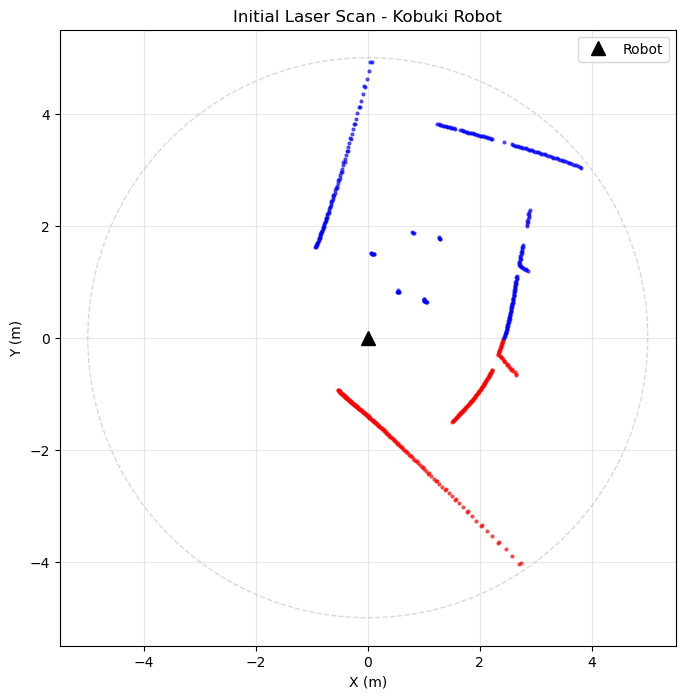

In [40]:
# Get current laser data from the working controller
laser_data = updated_controller.get_laser_data()

if laser_data is not None:
    print(f"✓ Got {len(laser_data)} laser points")
    # Plot laser scan
    plot_laser_scan(laser_data, title="Initial Laser Scan - Kobuki Robot")
else:
    print("No laser data available")

## 4. Test Sensor Noise

Test the `get_noisy_laser_data` function to verify that noise is being added correctly.

In [41]:
# Get clean laser data directly from controller
clean_data = updated_controller.get_laser_data()
print(f"Clean data: {len(clean_data)} points")

# Add noise to the data manually
distance_noise_std = 0.02  # 2 cm standard deviation
angle_noise_std = 0.005    # ~0.3 degrees standard deviation

noisy_data = clean_data.copy()
# Add Gaussian noise to angles (column 0)
noisy_data[:, 0] += np.random.normal(0, angle_noise_std, len(noisy_data))
# Add Gaussian noise to distances (column 1)
noisy_data[:, 1] += np.random.normal(0, distance_noise_std, len(noisy_data))
# Clip distances to valid range [0, max_distance]
noisy_data[:, 1] = np.clip(noisy_data[:, 1], 0, 5.0)

print(f"Noisy data: {len(noisy_data)} points")

# Compare a few points
print("\nComparison (first 5 points):")
print("Index | Clean (angle, dist) | Noisy (angle, dist) | Difference")
print("-" * 70)
for i in range(min(5, len(clean_data))):
    diff_angle = noisy_data[i,0] - clean_data[i,0]
    diff_dist = noisy_data[i,1] - clean_data[i,1]
    print(f"{i:5d} | ({clean_data[i,0]:6.3f}, {clean_data[i,1]:5.3f}) | "
          f"({noisy_data[i,0]:6.3f}, {noisy_data[i,1]:5.3f}) | "
          f"Δθ={diff_angle:7.4f}, Δd={diff_dist:6.3f}")

print("\n✓ Sensor noise test completed")

Clean data: 684 points
Noisy data: 684 points

Comparison (first 5 points):
Index | Clean (angle, dist) | Noisy (angle, dist) | Difference
----------------------------------------------------------------------
    0 | (-2.088, 1.075) | (-2.092, 1.095) | Δθ=-0.0038, Δd= 0.021
    1 | (-2.082, 1.078) | (-2.094, 1.088) | Δθ=-0.0117, Δd= 0.010
    2 | (-2.076, 1.075) | (-2.086, 1.092) | Δθ=-0.0100, Δd= 0.017
    3 | (-2.070, 1.079) | (-2.061, 1.080) | Δθ= 0.0085, Δd= 0.001
    4 | (-2.064, 1.082) | (-2.059, 1.093) | Δθ= 0.0043, Δd= 0.011

✓ Sensor noise test completed


## 5. Test Coordinate Transformations

Test the `transform_laser_to_global` function to verify transformations are working correctly.

Robot pose:
  Position: [-4.00011438 -4.00002795  0.06069469]
  Orientation (Euler): [ 0.00037188 -0.00111099 -0.0005177 ]

Transformed 684 points to global frame
Sample global points (first 5):
  Point 0: x=-4.545, y=-4.953, z=0.160
  Point 1: x=-4.544, y=-4.950, z=0.160
  Point 2: x=-4.514, y=-4.949, z=0.160
  Point 3: x=-4.512, y=-4.941, z=0.160
  Point 4: x=-4.520, y=-4.949, z=0.160

Transformed 684 points to global frame
Sample global points (first 5):
  Point 0: x=-4.545, y=-4.953, z=0.160
  Point 1: x=-4.544, y=-4.950, z=0.160
  Point 2: x=-4.514, y=-4.949, z=0.160
  Point 3: x=-4.512, y=-4.941, z=0.160
  Point 4: x=-4.520, y=-4.949, z=0.160


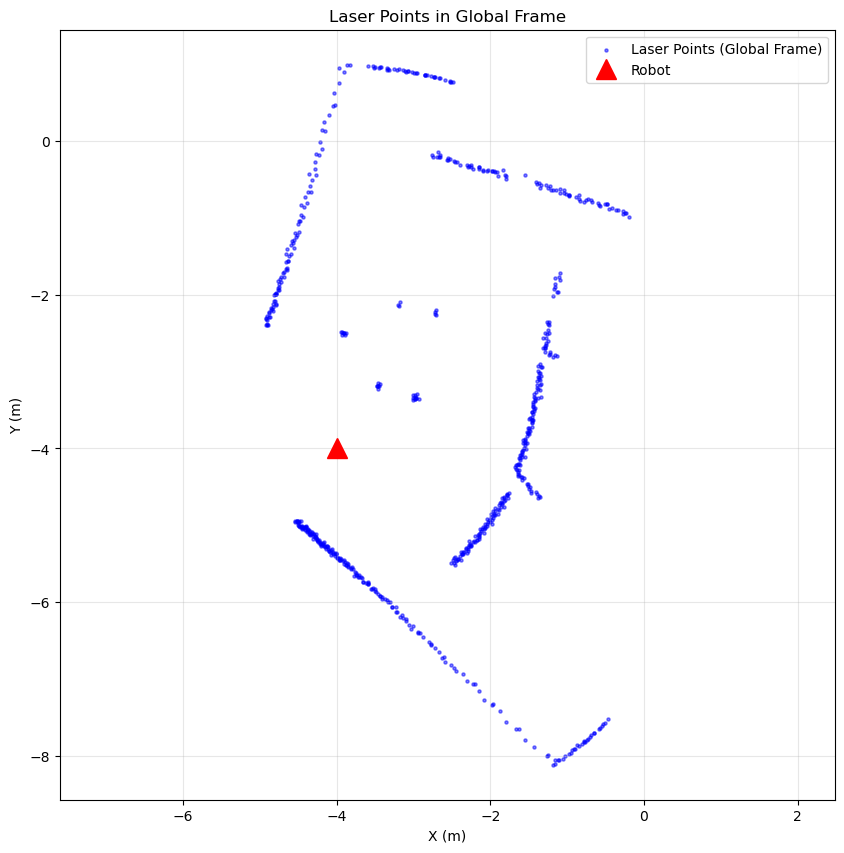


✓ Coordinate transformation test completed


In [42]:
# Get robot pose
robot_pose = updated_controller.get_pose()
print(f"Robot pose:")
print(f"  Position: {robot_pose[0]}")
print(f"  Orientation (Euler): {robot_pose[1]}")

# Get laser data with noise
laser_data = updated_controller.get_laser_data()
# Add noise
laser_data[:, 0] += np.random.normal(0, 0.005, len(laser_data))
laser_data[:, 1] += np.random.normal(0, 0.02, len(laser_data))
laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

# Transform to global frame
laser_points_global = transform_laser_to_global(robot_pose, laser_data)

print(f"\nTransformed {len(laser_points_global)} points to global frame")
print(f"Sample global points (first 5):")
for i in range(min(5, len(laser_points_global))):
    print(f"  Point {i}: x={laser_points_global[i,0]:.3f}, "
          f"y={laser_points_global[i,1]:.3f}, z={laser_points_global[i,2]:.3f}")

# Plot transformed points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(laser_points_global[:, 0], laser_points_global[:, 1],
          c='blue', s=5, alpha=0.5, label='Laser Points (Global Frame)')
ax.plot(robot_pose[0][0], robot_pose[0][1], 'r^', markersize=15, label='Robot')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Laser Points in Global Frame')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.show()

print("\n✓ Coordinate transformation test completed")

## 6. Test Occupancy Grid Mapper

Test the occupancy grid mapper with one scan to verify it's working.

Occupancy Grid initialized:
  Map size: 10m x 10m
  Cell size: 0.1m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Log-odds: l_occ=0.9, l_free=-0.7
Updating map with first scan...
Updating map with first scan...

Map statistics after 1 scan:
  Total cells: 10000
  Occupied: 107 (1.07%)
  Free: 0 (0.00%)
  Unknown: 9893 (98.93%)

Map statistics after 1 scan:
  Total cells: 10000
  Occupied: 107 (1.07%)
  Free: 0 (0.00%)
  Unknown: 9893 (98.93%)


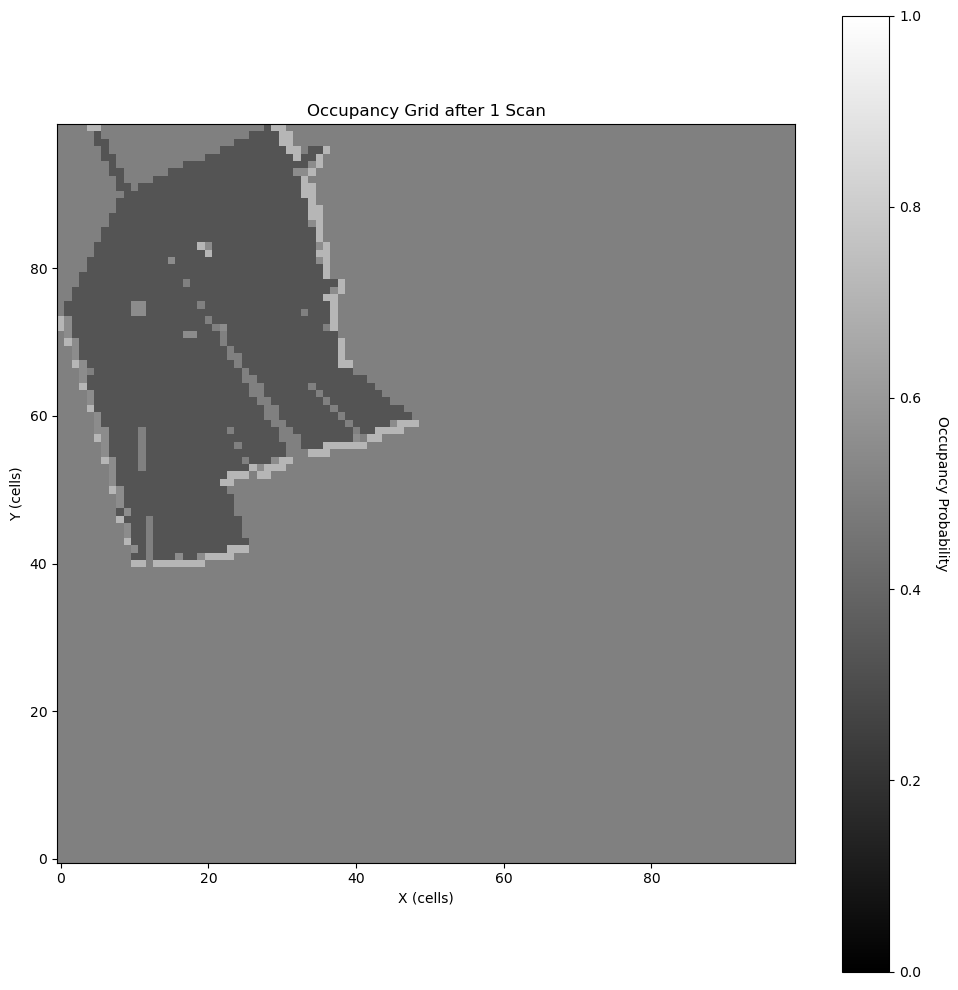


✓ Occupancy grid test completed


In [43]:
# Create occupancy grid mapper
test_mapper = OccupancyGridMapper(map_size=(10, 10), cell_size=0.1)

# Get robot pose and laser data
robot_pose = updated_controller.get_pose()
laser_data = updated_controller.get_laser_data()
# Add noise
laser_data[:, 0] += np.random.normal(0, 0.005, len(laser_data))
laser_data[:, 1] += np.random.normal(0, 0.02, len(laser_data))
laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

laser_points_global = transform_laser_to_global(robot_pose, laser_data)

# Update map
print("Updating map with first scan...")
test_mapper.update_map(robot_pose, laser_points_global)

# Show statistics
stats = test_mapper.get_statistics()
print(f"\nMap statistics after 1 scan:")
print(f"  Total cells: {stats['total_cells']}")
print(f"  Occupied: {stats['occupied_cells']} ({stats['occupied_percent']:.2f}%)")
print(f"  Free: {stats['free_cells']} ({stats['free_percent']:.2f}%)")
print(f"  Unknown: {stats['unknown_cells']} ({stats['unknown_percent']:.2f}%)")

# Visualize map
test_mapper.visualize_map(title="Occupancy Grid after 1 Scan")

print("\n✓ Occupancy grid test completed")

## 7. Test Exploration Planner

Test the exploration planner to verify it generates reasonable velocities.

In [44]:
# Create exploration planner
planner = ExplorationPlanner(v_nominal=0.15, d_safe=0.8)

# Get laser data
laser_data = updated_controller.get_laser_data()

# Plan velocities
v, w = planner.plan_step(laser_data)

print(f"Planned velocities based on current scan:")
print(f"  Linear velocity (v): {v:.3f} m/s")
print(f"  Angular velocity (w): {w:.3f} rad/s")

print("\n✓ Exploration planner test completed")

Exploration Planner initialized:
  Nominal velocity: 0.15 m/s
  Max angular velocity: 0.8 rad/s
  Safe distance: 0.8 m
  Repulsive gain: 0.5
Planned velocities based on current scan:
  Linear velocity (v): 0.150 m/s
  Angular velocity (w): 0.000 rad/s

✓ Exploration planner test completed


## 8. Summary and Next Steps

✓ **Connection test**: Successfully connected to CoppeliaSim and initialized Kobuki robot  
✓ **Sensor test**: Laser sensor working correctly  
✓ **Noise test**: Sensor noise addition functioning properly  
✓ **Transformation test**: Coordinate transformations working correctly  
✓ **Mapper test**: Occupancy grid updates correctly  
✓ **Planner test**: Exploration strategy generates reasonable velocities  

### Next Steps:

1. Implement full simulation loop (to be added in next cell)
2. Run experiments with different cell sizes
3. Test in static and dynamic scenarios
4. Generate maps and analysis

---